# Market Maker Simulation: P&L and Risk Management

**Track**: Extensions | **Difficulty**: ⭐⭐⭐⭐ Advanced | **Time**: 90-120 minutes

**Prerequisites**:
- Completed Core Track (all 3 notebooks)
- Understanding of market microstructure
- Familiarity with options Greeks (delta, gamma)
- Basic risk metrics (VaR, Sharpe ratio)

**Learning Objectives**:
1. Simulate market maker P&L during normal and stressed conditions
2. Understand inventory risk and hedging strategies
3. Calculate break-even spreads and capital requirements
4. Analyze market maker withdrawal triggers during flash crash
5. Model spread widening dynamics under liquidity stress

**Key Concepts**:
- Inventory management and position limits
- Delta hedging with ETFs vs underlying securities
- Value at Risk (VaR) and Expected Shortfall (ES)
- Market impact and adverse selection

---

## Setup

In [1]:
# ============================================================================
# SETUP - Market Maker Simulation
# ============================================================================

import sys
import os
from pathlib import Path

# Detect environment
try:
    import google.colab
    IN_COLAB = True
    print("🌐 Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("💻 Running in local Jupyter environment")

# Setup for Colab
if IN_COLAB:
    print("\n📥 Setting up Colab environment...")
    
    if not os.path.exists('/content/etf-flash-crash-2015'):
        print("  Cloning repository...")
        !git clone https://github.com/shiong-tan/etf-flash-crash-2015.git /content/etf-flash-crash-2015
        print("  ✅ Repository cloned")
    else:
        print("  ✅ Repository exists")
    
    print("  Installing dependencies...")
    !pip install -q pandas numpy matplotlib seaborn scipy
    print("  ✅ Dependencies installed")
    
    os.chdir('/content/etf-flash-crash-2015')
    sys.path.insert(0, '/content/etf-flash-crash-2015/src')
    
else:
    print("\n📂 Setting up local environment...")
    notebook_dir = Path().resolve()
    
    # Determine src directory location based on notebook location
    # Case 1: In notebooks/core/ or notebooks/extensions/ → go up 2 levels
    if notebook_dir.parent.name == 'notebooks':
        project_root = notebook_dir.parent.parent
        src_dir = project_root / 'src'
    # Case 2: In notebooks/ directory → go up 1 level
    elif notebook_dir.name == 'notebooks':
        project_root = notebook_dir.parent
        src_dir = project_root / 'src'
    # Case 3: In project root (has notebooks/ subdirectory) → use directly
    elif (notebook_dir / 'notebooks').exists():
        project_root = notebook_dir
        src_dir = project_root / 'src'
    # Case 4: Fallback - assume we're one level deep
    else:
        project_root = notebook_dir.parent
        src_dir = project_root / 'src'
    
    sys.path.insert(0, str(src_dir))
    print(f"  ✅ Added src to path: {src_dir}")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from market_maker_pnl import MarketMakerSimulator, MarketMakerPosition, HedgeStatus
from order_book_dynamics import FlashCrashOrderBook

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
np.random.seed(42)

if IN_COLAB:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('retina')
else:
    try:
        get_ipython().run_line_magic('matplotlib', 'inline')
    except:
        pass

print("\n" + "="*60)
print("✅ SETUP COMPLETE - Ready for market maker simulation!")
print("="*60)

💻 Running in local Jupyter environment

📂 Setting up local environment...
  ✅ Added src to path: /Users/shiongtan/projects/etf-flash-crash-2015/src

✅ SETUP COMPLETE - Ready for market maker simulation!


---

## Part 1: Market Maker Basics

### Exercise 1.1: Quote Market with Fixed Spread

Simulate a market maker quoting SPY with a 2 basis point spread.

In [2]:
# Initialize market maker for SPY
mm = MarketMakerSimulator(
    symbol="SPY",
    initial_capital=1_000_000,  # $1M capital
    max_inventory=5_000,        # Max 5000 shares long or short
    target_spread_bps=2.0       # 2 basis point spread
)

# Current market: SPY at $200
fair_value = 200.00

# Generate bid/ask quotes
# The market maker quotes around fair value with target spread
# Spread = (ask - bid) / midpoint * 10000 basis points
# 
# For 2 bps spread on $200:
# spread_dollars = 200 * 0.0002 = $0.04
# bid = 200 - 0.02 = $199.98
# ask = 200 + 0.02 = $200.02

quotes = mm.quote_market(
    fair_value=fair_value,
    hedge_status=HedgeStatus.FULL,  # Can fully hedge
    volatility=0.01  # 1% daily volatility
)

print(f"Fair Value: ${fair_value:.2f}")
print(f"Bid: ${quotes['bid']:.2f}")
print(f"Ask: ${quotes['ask']:.2f}")
print(f"Spread: ${quotes['ask'] - quotes['bid']:.4f}")
print(f"Spread (bps): {quotes['spread_bps']:.2f}")

Fair Value: $200.00
Bid: $199.98
Ask: $200.02
Spread: $0.0420
Spread (bps): 2.10


### Exercise 1.2: Execute Trades and Track P&L

Simulate a trading day with buy and sell orders.

In [3]:
# Simulate trades throughout the day
trades = [
    {'side': 'buy', 'price': 199.98, 'quantity': 1000},   # Customer sells to us at bid
    {'side': 'sell', 'price': 200.02, 'quantity': 800},   # Customer buys from us at ask
    {'side': 'buy', 'price': 199.97, 'quantity': 1500},   
    {'side': 'sell', 'price': 200.01, 'quantity': 1200},
]

print("=== TRADING SIMULATION ===")
for i, trade in enumerate(trades, 1):
    accepted = mm.execute_trade(
        size=trade['quantity'],
        price=trade['price'],
        side=trade['side'],
        fair_value=fair_value,
        can_hedge=True  # Can hedge in normal market
    )
    
    if accepted:
        print(f"\nTrade {i}: {trade['side'].upper()} {trade['quantity']} @ ${trade['price']:.2f}")
        print(f"  Position: {mm.position.etf_inventory} shares")
        print(f"  Hedge: {mm.position.underlying_hedge} shares")
        print(f"  Net Delta: {mm.position.net_delta()} shares")
    else:
        print(f"\nTrade {i}: REJECTED (would exceed inventory limit)")

# Mark-to-market at end of day
eod_price = 200.05
mtm_result = mm.mark_to_market(eod_price)

print(f"\n=== END OF DAY ===")
print(f"Final Position: {mm.position.etf_inventory} shares")
print(f"Mark-to-Market Price: ${eod_price:.2f}")
print(f"ETF P&L: ${mtm_result['etf_pnl']:,.2f}")
print(f"Total P&L: ${mtm_result['total_pnl']:,.2f}")
print(f"Return on Capital: {mtm_result['return_pct']:.4f}%")
print(f"Current Capital: ${mtm_result['capital']:,.2f}")

=== TRADING SIMULATION ===

Trade 1: BUY 1000 @ $199.98
  Position: -1000 shares
  Hedge: 1000 shares
  Net Delta: 0 shares

Trade 2: SELL 800 @ $200.02
  Position: -200 shares
  Hedge: 200 shares
  Net Delta: 0 shares

Trade 3: BUY 1500 @ $199.97
  Position: -1700 shares
  Hedge: 1700 shares
  Net Delta: 0 shares

Trade 4: SELL 1200 @ $200.01
  Position: -500 shares
  Hedge: 500 shares
  Net Delta: 0 shares

=== END OF DAY ===
Final Position: -500 shares
Mark-to-Market Price: $200.05
ETF P&L: $-39.41
Total P&L: $-39.41
Return on Capital: -0.0039%
Current Capital: $999,960.59


**Question**: Why does the market maker have inventory risk despite quoting tight spreads?

---

## Part 2: Inventory Management and Skewing

### Exercise 2.1: Inventory-Dependent Quoting

Market makers adjust quotes based on inventory to encourage mean reversion.

=== INVENTORY-DEPENDENT QUOTING ===
Fair Value: $200.00

 Inventory      Bid      Ask  Midpoint    Skew
     -4000 200.7790 200.8210  200.8000  0.8000
     -2000 200.3790 200.4210  200.4000  0.4000
         0 199.9790 200.0210  200.0000  0.0000
      2000 199.5790 199.6210  199.6000 -0.4000
      4000 199.1790 199.2210  199.2000 -0.8000


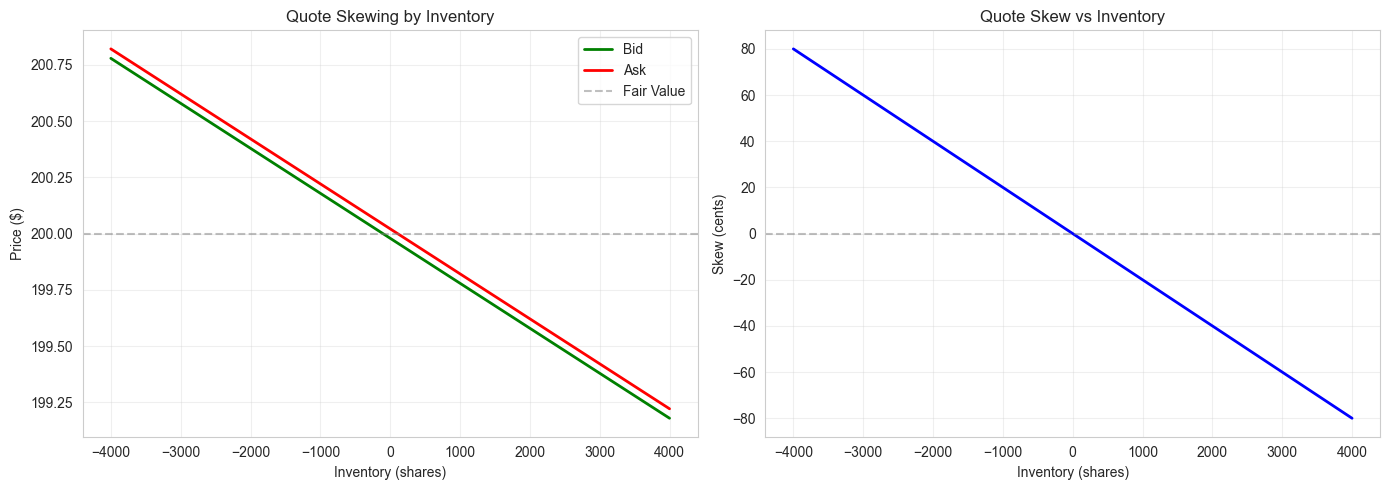


💡 Insight: With +4000 shares (long), market maker skews quotes DOWN
   to encourage selling, reducing inventory risk.


In [4]:
# Reset market maker
mm = MarketMakerSimulator("SPY", 1_000_000, 5_000, 2.0)

fair_value = 200.00
inventory_levels = [-4000, -2000, 0, 2000, 4000]

print("=== INVENTORY-DEPENDENT QUOTING ===")
print(f"Fair Value: ${fair_value:.2f}\n")

results = []
for inventory in inventory_levels:
    # Manually set inventory to demonstrate skewing
    # (In production, inventory builds through actual trades)
    mm.position.etf_inventory = inventory
    
    quotes = mm.quote_market(
        fair_value=fair_value,
        hedge_status=HedgeStatus.FULL,
        volatility=0.01
    )
    
    midpoint = (quotes['bid'] + quotes['ask']) / 2
    skew = midpoint - fair_value
    
    results.append({
        'Inventory': inventory,
        'Bid': quotes['bid'],
        'Ask': quotes['ask'],
        'Midpoint': midpoint,
        'Skew': skew
    })

df = pd.DataFrame(results)
print(df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

# Visualize quote skewing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Bid/Ask vs Inventory
ax1.plot(df['Inventory'], df['Bid'], 'g-', label='Bid', linewidth=2)
ax1.plot(df['Inventory'], df['Ask'], 'r-', label='Ask', linewidth=2)
ax1.axhline(fair_value, color='gray', linestyle='--', alpha=0.5, label='Fair Value')
ax1.set_xlabel('Inventory (shares)')
ax1.set_ylabel('Price ($)')
ax1.set_title('Quote Skewing by Inventory')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Midpoint Skew
ax2.plot(df['Inventory'], df['Skew'] * 100, 'b-', linewidth=2)
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Inventory (shares)')
ax2.set_ylabel('Skew (cents)')
ax2.set_title('Quote Skew vs Inventory')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 Insight: With +4000 shares (long), market maker skews quotes DOWN")
print(f"   to encourage selling, reducing inventory risk.")

### Exercise 2.2: Calculate Inventory Risk (VaR)

Quantify risk from holding inventory positions.

In [5]:
# Assume SPY daily volatility = 1% (annualized ~16%)
daily_volatility = 0.01
price = 200.00

# Different inventory levels
inventories = [0, 1000, 2500, 5000]
confidence_levels = [0.95, 0.99]

print("=== INVENTORY RISK ANALYSIS ===")
print(f"Price: ${price:.2f}, Daily Vol: {daily_volatility*100:.1f}%\n")

for inventory in inventories:
    position_value = inventory * price
    position_volatility = position_value * daily_volatility
    
    print(f"\nInventory: {inventory:,} shares (${position_value:,.0f})")
    
    for conf in confidence_levels:
        # VaR = Position * Volatility * Z-score
        z_score = stats.norm.ppf(conf)
        var = position_volatility * z_score
        
        # Expected Shortfall (average loss beyond VaR)
        es = position_volatility * stats.norm.pdf(z_score) / (1 - conf)
        
        print(f"  VaR ({conf*100:.0f}%): ${var:,.2f}")
        print(f"  Expected Shortfall: ${es:,.2f}")

# Calculate break-even spread to cover inventory risk
# For 2500 shares, VaR(99%) ≈ $11,650
# If trading 10,000 shares/day, what spread covers this risk?

inventory = 2500
daily_volume = 10000
z_99 = stats.norm.ppf(0.99)
var_99 = inventory * price * daily_volatility * z_99  # ~$11,650

# Break-even: spread revenue must cover daily VaR
# Daily revenue = daily_volume * spread_per_share
# Need: daily_volume * spread_per_share >= var_99
breakeven_spread = var_99 / daily_volume  # $/share
breakeven_bps = (breakeven_spread / price) * 10000  # basis points

print(f"\n💡 Break-Even Analysis:")
print(f"   Daily volume: {daily_volume:,} shares")
print(f"   VaR(99%) for {inventory} share position: ${var_99:,.2f}")
print(f"   Break-even spread: ${breakeven_spread:.4f}/share ({breakeven_bps:.2f} bps)")
print(f"   Current spread (2 bps) {'covers' if 2 > breakeven_bps else 'does NOT cover'} this risk")

=== INVENTORY RISK ANALYSIS ===
Price: $200.00, Daily Vol: 1.0%


Inventory: 0 shares ($0)
  VaR (95%): $0.00
  Expected Shortfall: $0.00
  VaR (99%): $0.00
  Expected Shortfall: $0.00

Inventory: 1,000 shares ($200,000)
  VaR (95%): $3,289.71
  Expected Shortfall: $4,125.43
  VaR (99%): $4,652.70
  Expected Shortfall: $5,330.43

Inventory: 2,500 shares ($500,000)
  VaR (95%): $8,224.27
  Expected Shortfall: $10,313.56
  VaR (99%): $11,631.74
  Expected Shortfall: $13,326.07

Inventory: 5,000 shares ($1,000,000)
  VaR (95%): $16,448.54
  Expected Shortfall: $20,627.13
  VaR (99%): $23,263.48
  Expected Shortfall: $26,652.14

💡 Break-Even Analysis:
   Daily volume: 10,000 shares
   VaR(99%) for 2500 share position: $11,631.74
   Break-even spread: $1.1632/share (58.16 bps)
   Current spread (2 bps) does NOT cover this risk


---

## Part 3: Hedging Strategies

### Exercise 3.1: Delta Hedging with Futures

Hedge ETF inventory with S&P 500 futures.

In [6]:
# Market maker accumulates SPY inventory
spy_position = 3000  # Long 3000 shares SPY
spy_price = 200.00
position_value = spy_position * spy_price  # $600,000

# Hedge with ES (E-mini S&P 500) futures
es_multiplier = 50  # Each contract = $50 × S&P 500 index
sp500_level = 4000  # S&P 500 index at 4000
es_contract_value = es_multiplier * sp500_level  # $200,000 per contract

# Calculate number of futures contracts to hedge
# SPY tracks S&P 500 with ~1:1 delta (actually ~0.20 due to index scaling)
# Each SPY share ≈ 0.05 × S&P 500 index
# 
# Hedge ratio: (SPY position value) / (ES contract value)
hedge_contracts = position_value / es_contract_value  # Should be ~3

print("=== DELTA HEDGING ANALYSIS ===")
print(f"SPY Position: {spy_position:,} shares @ ${spy_price:.2f}")
print(f"Position Value: ${position_value:,.0f}")
print(f"\nES Contract Value: ${es_contract_value:,.0f}")
print(f"Hedge Contracts: {hedge_contracts:.1f} (round to {round(hedge_contracts)})")
print(f"Hedge Value: ${round(hedge_contracts) * es_contract_value:,.0f}")

# Scenario: Market falls 1%
spy_loss = position_value * -0.01
futures_gain = round(hedge_contracts) * es_contract_value * 0.01  # Short futures gain when market falls
net_pnl = spy_loss + futures_gain

print(f"\n=== SCENARIO: Market -1% ===")
print(f"SPY Loss: ${spy_loss:,.2f}")
print(f"Futures Gain: ${futures_gain:,.2f}")
print(f"Net P&L: ${net_pnl:,.2f}")
print(f"\n✓ Hedge {'effective' if abs(net_pnl) < 1000 else 'needs adjustment'}")

=== DELTA HEDGING ANALYSIS ===
SPY Position: 3,000 shares @ $200.00
Position Value: $600,000

ES Contract Value: $200,000
Hedge Contracts: 3.0 (round to 3)
Hedge Value: $600,000

=== SCENARIO: Market -1% ===
SPY Loss: $-6,000.00
Futures Gain: $6,000.00
Net P&L: $0.00

✓ Hedge effective


### Exercise 3.2: Hedging Limitations During Flash Crash

Why hedging breaks down when underlying securities halt.

In [7]:
# August 24, 2015 scenario
# Market maker has ETF position but underlying stocks halted

etf_position = 5000  # Long 5000 shares of sector ETF
etf_components = 100  # ETF holds 100 stocks

# At 9:35 AM: 60% of components halted
stocks_trading = 40
stocks_halted = 60

# ETF trading at $50, down 20% from $62.50
etf_current_price = 50.00
etf_prev_close = 62.50

position_value = etf_position * etf_current_price  # $250,000
unrealized_loss = etf_position * (etf_current_price - etf_prev_close)  # -$62,500

# Can only hedge 40% of position (trading stocks)
hedgeable_portion = stocks_trading / etf_components
unhedged_portion = stocks_halted / etf_components

hedgeable_value = position_value * hedgeable_portion
unhedged_value = position_value * unhedged_portion

print("=== FLASH CRASH HEDGING CRISIS ===")
print(f"ETF Position: {etf_position:,} shares @ ${etf_current_price:.2f}")
print(f"Position Value: ${position_value:,.0f}")
print(f"Unrealized Loss: ${unrealized_loss:,.0f} ({((etf_current_price/etf_prev_close)-1)*100:.1f}%)")
print(f"\nComponent Status:")
print(f"  Trading: {stocks_trading} ({hedgeable_portion*100:.0f}%)")
print(f"  Halted: {stocks_halted} ({unhedged_portion*100:.0f}%)")
print(f"\nHedgeable Value: ${hedgeable_value:,.0f}")
print(f"Unhedged Value: ${unhedged_value:,.0f}")

# Scenario: Halted stocks fall another 10% when they reopen
additional_decline = 0.10
additional_loss = unhedged_value * additional_decline

print(f"\n=== RISK SCENARIO ===")
print(f"If halted stocks fall {additional_decline*100:.0f}% more:")
print(f"Additional loss: ${additional_loss:,.0f}")
print(f"Total potential loss: ${unrealized_loss + additional_loss:,.0f}")
print(f"\n⚠️  Cannot hedge 60% of position = unquantifiable risk")
print(f"Rational decision: STOP MARKET MAKING until can hedge")

=== FLASH CRASH HEDGING CRISIS ===
ETF Position: 5,000 shares @ $50.00
Position Value: $250,000
Unrealized Loss: $-62,500 (-20.0%)

Component Status:
  Trading: 40 (40%)
  Halted: 60 (60%)

Hedgeable Value: $100,000
Unhedged Value: $150,000

=== RISK SCENARIO ===
If halted stocks fall 10% more:
Additional loss: $15,000
Total potential loss: $-47,500

⚠️  Cannot hedge 60% of position = unquantifiable risk
Rational decision: STOP MARKET MAKING until can hedge


**Question**: Why did market makers withdraw liquidity during the flash crash despite apparent profit opportunities?

---

## Part 4: Flash Crash Market Making Simulation

### Exercise 4.1: Normal vs Stressed Spread Widening

=== SPREAD WIDENING DYNAMICS ===
Scenario        Volatility   Hedge Status    Spread (bps) Spread ($)  
Normal             1.0%      full_hedge_available      2.1      $    0.04
Elevated           2.0%      full_hedge_available      2.2      $    0.04
High Stress        5.0%      partial_hedge_available     25.0      $    0.50
Flash Crash       10.0%      no_hedge_available    200.0      $    4.00


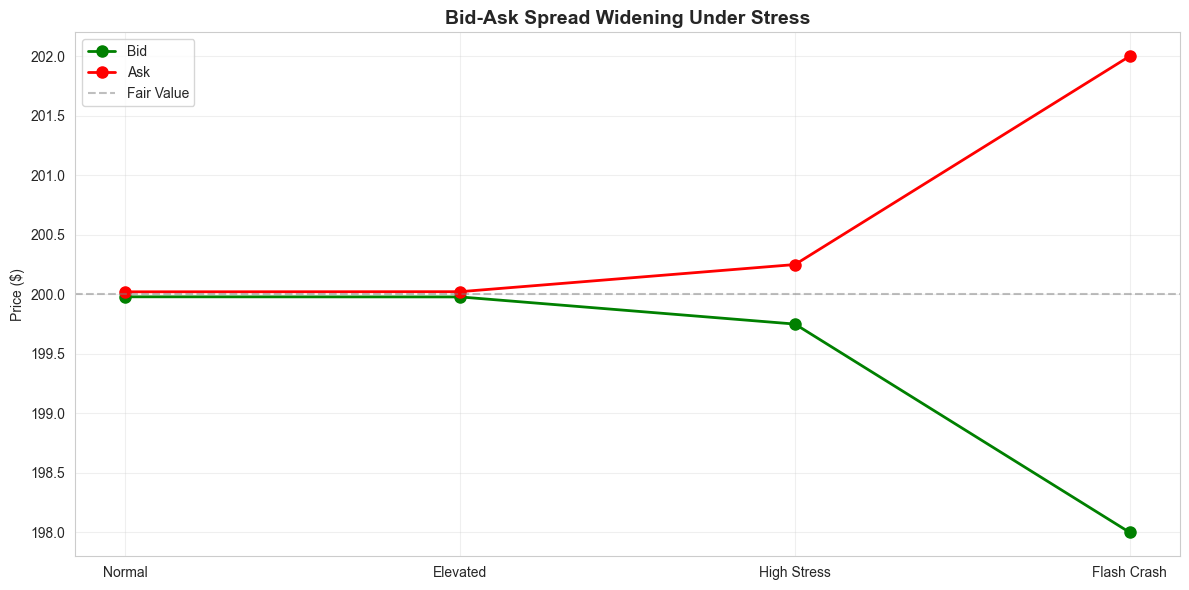


💡 Spread increased 95x from normal to flash crash


In [8]:
# Simulate market maker behavior as volatility increases

volatility_scenarios = [
    {'name': 'Normal', 'vol': 0.01, 'hedge': HedgeStatus.FULL},
    {'name': 'Elevated', 'vol': 0.02, 'hedge': HedgeStatus.FULL},
    {'name': 'High Stress', 'vol': 0.05, 'hedge': HedgeStatus.PARTIAL},
    {'name': 'Flash Crash', 'vol': 0.10, 'hedge': HedgeStatus.NONE},
]

print("=== SPREAD WIDENING DYNAMICS ===")
print(f"{'Scenario':<15} {'Volatility':<12} {'Hedge Status':<15} {'Spread (bps)':<12} {'Spread ($)':<12}")
print("=" * 75)

fair_value = 200.00
mm = MarketMakerSimulator("SPY", 1_000_000, 5_000, 2.0)
results = []

for scenario in volatility_scenarios:
    quotes = mm.quote_market(
        fair_value=fair_value,
        hedge_status=scenario['hedge'],
        volatility=scenario['vol']
    )
    
    if quotes:  # Market maker still quoting
        spread_dollars = quotes['ask'] - quotes['bid']
        spread_bps = quotes['spread_bps']
        
        results.append({
            'Scenario': scenario['name'],
            'Volatility': f"{scenario['vol']*100:.1f}%",
            'Hedge_Status': scenario['hedge'].value,
            'Spread_bps': spread_bps,
            'Spread_dollars': spread_dollars,
            'Bid': quotes['bid'],
            'Ask': quotes['ask']
        })
        
        print(f"{scenario['name']:<15} {scenario['vol']*100:>6.1f}%      {scenario['hedge'].value:<15} {spread_bps:>8.1f}      ${spread_dollars:>8.2f}")
    else:
        print(f"{scenario['name']:<15} {scenario['vol']*100:>6.1f}%      {'WITHDRAWN':>30}")

# Visualize spread widening
if results:
    df_spreads = pd.DataFrame(results)
    
    plt.figure(figsize=(12, 6))
    x = range(len(df_spreads))
    plt.plot(x, df_spreads['Bid'], 'g-o', label='Bid', linewidth=2, markersize=8)
    plt.plot(x, df_spreads['Ask'], 'r-o', label='Ask', linewidth=2, markersize=8)
    plt.axhline(fair_value, color='gray', linestyle='--', alpha=0.5, label='Fair Value')
    plt.xticks(x, df_spreads['Scenario'])
    plt.ylabel('Price ($)')
    plt.title('Bid-Ask Spread Widening Under Stress', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    spread_increase = results[-1]['Spread_bps'] / results[0]['Spread_bps']
    print(f"\n💡 Spread increased {spread_increase:.0f}x from normal to flash crash")

### Exercise 4.2: Market Maker Withdrawal Triggers

In [9]:
# Conditions that cause market makers to withdraw

withdrawal_conditions = [
    {
        'condition': 'Hedging Availability',
        'normal': '100% hedgeable',
        'flash_crash': '40% hedgeable (60% halted)',
        'decision': 'WITHDRAW'
    },
    {
        'condition': 'Price Discovery',
        'normal': 'Continuous trading',
        'flash_crash': 'Multiple LULD halts (gaps)',
        'decision': 'WITHDRAW'
    },
    {
        'condition': 'Fair Value Estimate',
        'normal': 'Confident (real-time prices)',
        'flash_crash': 'Unknown (stale iNAV)',
        'decision': 'WITHDRAW'
    },
    {
        'condition': 'Inventory Limits',
        'normal': 'Within limits',
        'flash_crash': 'Near/at max (one-sided flow)',
        'decision': 'WIDEN SPREAD or WITHDRAW'
    },
    {
        'condition': 'Capital at Risk',
        'normal': '$10-50K VaR',
        'flash_crash': '$500K+ VaR (unknown distribution)',
        'decision': 'WITHDRAW'
    },
]

df_conditions = pd.DataFrame(withdrawal_conditions)
print("=== MARKET MAKER WITHDRAWAL TRIGGERS ===")
print(df_conditions.to_string(index=False))

print(f"\n⚠️  On August 24, 2015, ALL conditions triggered simultaneously")
print(f"Result: Rational market makers withdrew, causing liquidity vacuum")
print(f"\nThis wasn't market maker failure—it was risk management working as designed")
print(f"The failure was market structure, not individual participants")

=== MARKET MAKER WITHDRAWAL TRIGGERS ===
           condition                       normal                       flash_crash                 decision
Hedging Availability               100% hedgeable        40% hedgeable (60% halted)                 WITHDRAW
     Price Discovery           Continuous trading        Multiple LULD halts (gaps)                 WITHDRAW
 Fair Value Estimate Confident (real-time prices)              Unknown (stale iNAV)                 WITHDRAW
    Inventory Limits                Within limits      Near/at max (one-sided flow) WIDEN SPREAD or WITHDRAW
     Capital at Risk                  $10-50K VaR $500K+ VaR (unknown distribution)                 WITHDRAW

⚠️  On August 24, 2015, ALL conditions triggered simultaneously
Result: Rational market makers withdrew, causing liquidity vacuum

This wasn't market maker failure—it was risk management working as designed
The failure was market structure, not individual participants


---

## Part 5: Capital Requirements Analysis

### Exercise 5.1: Calculate Required Capital

In [10]:
# How much capital does a market maker need?

# Daily trading parameters
daily_volume = 50_000  # shares
avg_price = 200.00
max_inventory = 5_000  # shares
daily_vol = 0.01       # 1% daily volatility

# Capital components
# 1. Inventory capital
inventory_capital = max_inventory * avg_price  # $1,000,000

# 2. VaR buffer (99% confidence, 1-day)
var_99 = inventory_capital * daily_vol * 2.33  # ~$23,300
var_buffer = var_99 * 3  # 3x VaR for safety

# 3. Operational reserve (hedging costs, exchange fees)
operational_reserve = 100_000

# Total capital requirement
total_capital = inventory_capital + var_buffer + operational_reserve

print("=== MARKET MAKER CAPITAL REQUIREMENTS ===")
print(f"Trading Parameters:")
print(f"  Daily Volume: {daily_volume:,} shares")
print(f"  Average Price: ${avg_price:.2f}")
print(f"  Max Inventory: {max_inventory:,} shares")
print(f"  Daily Volatility: {daily_vol*100:.1f}%")
print(f"\nCapital Breakdown:")
print(f"  Inventory Capital: ${inventory_capital:,}")
print(f"  VaR Buffer (3× VaR99): ${var_buffer:,.0f}")
print(f"  Operational Reserve: ${operational_reserve:,}")
print(f"  " + "=" * 40)
print(f"  Total Required: ${total_capital:,}")

# Return on capital analysis
spread_bps = 2.0
spread_per_share = avg_price * (spread_bps / 10000)
daily_revenue = daily_volume * spread_per_share
annual_revenue = daily_revenue * 252  # trading days

# Costs
annual_costs = annual_revenue * 0.30  # 30% for ops, tech, etc.
annual_profit = annual_revenue - annual_costs
roc = (annual_profit / total_capital) * 100

print(f"\n=== PROFITABILITY ANALYSIS ===")
print(f"Daily Revenue (2 bps spread): ${daily_revenue:,.2f}")
print(f"Annual Revenue (252 days): ${annual_revenue:,.0f}")
print(f"Annual Costs (30%): ${annual_costs:,.0f}")
print(f"Annual Profit: ${annual_profit:,.0f}")
print(f"Return on Capital: {roc:.2f}%")

print(f"\n💡 Market making is capital intensive:")
print(f"   ${total_capital:,} required to earn ${annual_profit:,.0f}/year ({roc:.1f}% ROC)")
print(f"   High fixed costs, low margins, volume-dependent")

=== MARKET MAKER CAPITAL REQUIREMENTS ===
Trading Parameters:
  Daily Volume: 50,000 shares
  Average Price: $200.00
  Max Inventory: 5,000 shares
  Daily Volatility: 1.0%

Capital Breakdown:
  Inventory Capital: $1,000,000.0
  VaR Buffer (3× VaR99): $69,900
  Operational Reserve: $100,000
  Total Required: $1,169,900.0

=== PROFITABILITY ANALYSIS ===
Daily Revenue (2 bps spread): $2,000.00
Annual Revenue (252 days): $504,000
Annual Costs (30%): $151,200
Annual Profit: $352,800
Return on Capital: 30.16%

💡 Market making is capital intensive:
   $1,169,900.0 required to earn $352,800/year (30.2% ROC)
   High fixed costs, low margins, volume-dependent


---

## Summary and Key Takeaways

### What We Learned:

1. **Market Making P&L**:
   - Revenue from bid-ask spread capture
   - Inventory risk from directional exposure
   - Quote skewing to manage positions

2. **Risk Management**:
   - VaR and Expected Shortfall calculations
   - Break-even spreads to cover risk
   - Capital requirements for sustained operations

3. **Hedging Strategies**:
   - Delta hedging with futures
   - Hedging breaks down when instruments halt
   - Unhedgeable risk = no market making

4. **Flash Crash Dynamics**:
   - Spread widening (2 bps → 100+ bps)
   - Withdrawal triggers (hedging, price discovery, fair value)
   - Rational response to extreme uncertainty

5. **Capital Economics**:
   - $1M+ capital for small operation
   - Low margins (5-15% ROC)
   - High fixed costs, volume-dependent profits

### Critical Insights:

- **Market makers are NOT obligated to provide liquidity** during dysfunction
- **Withdrawal is rational risk management**, not predatory behavior
- **August 24, 2015 was a market structure failure**, not market maker failure
- **Liquidity is conditional** on ability to hedge and price discovery

---

## Next Steps

✅ **Completed**: Market Maker Simulation

**Continue to**:
- Notebook 02: Liquidity Microstructure (Kyle's lambda, Amihud measure) - Planned
- Notebook 03: Research Questions (open-ended explorations) - Planned

**Additional Reading**:
- Guide: `guide/04-market-maker-perspective/`
- Case Study: `guide/03-deep-dive/case-study-*.md`

---

*Generated for ETF Flash Crash 2015 Educational Project - Extensions Track*